[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kaggle-runa/MameLand_vol3/blob/main/src/notebook/03_%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E5%AD%A6%E7%BF%92.ipynb
)

In [ ]:
# 必要なライブラリのimport
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import lightgbm as lgb

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [2]:
# google driveへのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


データはGoogle Driveの競馬分析/dataレポジトリにあることを想定しています。  
自分のフォルダ構成に応じてデータのパスを適宜変更して下さい。


- 競馬分析/
  - data/  # 分析に使う生データ
  - feature_data/  # 02_データの前処理.ipynbで作成した生データを加工したデータ
  - simulation_data/ # 05_馬券の購入シミュレーション(ワイド・複勝).ipynbで利用する回収率を計算するためのデータ
  - notebooks/  # 競馬分析を行うnotebook
    - 00_データのスクレイピング.ipynb
    - 01_競馬データ可視化.ipynb
    - 02_データの前処理.ipynb
    - 03_モデルの学習.ipynb
    - 04_新規データでの予測.ipynb
    - 05_馬券の購入シミュレーション(ワイド・複勝).ipynb
  - model/  # 作成したモデルを格納するレポジトリ

In [18]:
# データの読み込み
data = pd.read_csv('/content/drive/MyDrive/競馬分析/feature_data/feature_race_result.csv')

In [20]:
# データの分割
# データは2022年1月5日〜2024年9月29日まであるので2024年8月までを学習用、それ以降を検証用としてデータを分割します。

train = data[data['event_date'] < '2024-09-01']
test = data[data['event_date'] >= '2024-09-01']

print('trainデータの件数', len(train))
print('testデータの件数', len(test))

trainデータの件数 129048
testデータの件数 3238


In [21]:
# 説明変数の設定
train_X = train.drop(['race_id', 'event_date', 'finish_position', 'target'], axis=1)
test_X = test.drop(['race_id',  'event_date', 'finish_position', 'target'], axis=1)

# 目的変数の設定
train_y = train['target']
test_y = test['target']

In [22]:
# データをlightgbm用に変換
lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(test_X, test_y, reference=lgb_train)

# lightGBMのパラメータ設定
params = {
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'random_state': 0,
    'objective': 'binary',
    'metric': 'binary_logloss'
}

# モデルの学習
model = lgb.train(params, lgb_train,
                               valid_sets=[lgb_train, lgb_eval],
                               num_boost_round=1000,
                               callbacks=[lgb.early_stopping(100),
                                          lgb.log_evaluation(period=100)
                                        ])

# モデルの保存
model.save_model('/content/drive/MyDrive/競馬分析/model/final_model.txt')

[LightGBM] [Info] Number of positive: 28233, number of negative: 100815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1510
[LightGBM] [Info] Number of data points in the train set: 129048, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218779 -> initscore=-1.272796
[LightGBM] [Info] Start training from score -1.272796
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.425099	valid_1's binary_logloss: 0.436649
[200]	training's binary_logloss: 0.403068	valid_1's binary_logloss: 0.416336
[300]	training's binary_logloss: 0.39575	valid_1's binary_logloss: 0.412295
[400]	training's binary_logloss: 0.3915	valid_1's binary_logloss: 0.411484
[500]	training's binary_logloss: 0.387755	valid_1's binary_logloss: 0.411

<Figure size 1000x700 with 0 Axes>

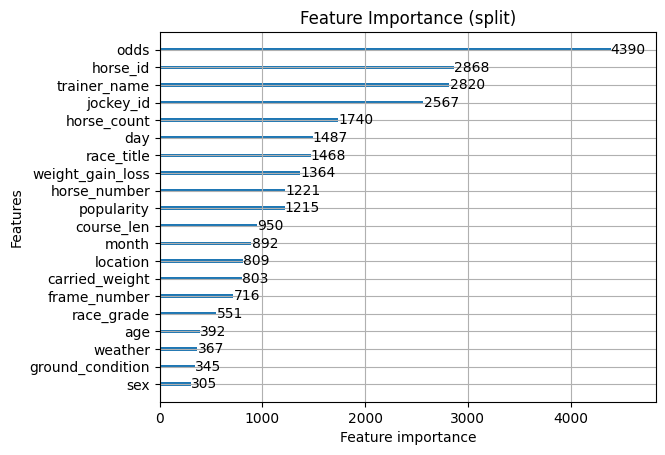

<Figure size 1000x700 with 0 Axes>

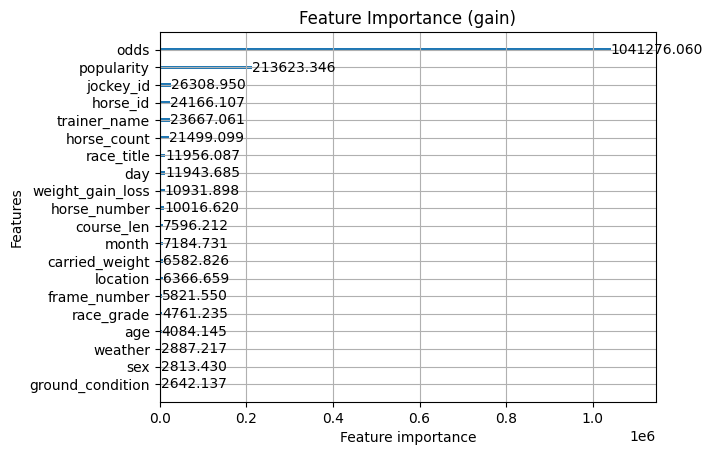

In [23]:
# 特徴量重要度の可視化
plt.figure(figsize=(10, 7))
lgb.plot_importance(model, max_num_features=20, importance_type='split')
plt.title('Feature Importance (split)')
plt.show()

plt.figure(figsize=(10, 7))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance (gain)')
plt.show()

In [24]:
# 予測の実行(train)
y_pred = model.predict(train_X, num_iteration=model.best_iteration)

# 予測値の代入
train['pred'] = y_pred

/var/folders/f2/dyf3ym2n7kgb2_9yskmdtj0jr9qsrg/T/ipykernel_94723/2842746524.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred'] = y_pred


In [25]:
# レースごとに確率が高い馬３頭に1,それ以外に0のラベルを付与する処理
# 空のデータフレームとリストを作成
submit = pd.DataFrame()
pred_list = []

for race in train['race_id'].unique():
    # レースごとのデータを抽出
    data = train[train['race_id'] == race]

    # 確率が高い順に並び替え
    data = data.sort_values(by='pred', ascending=False).reset_index()
    for index, data_ in data.iterrows():
        # 上位3頭に1、それ以外の馬に0のラベルを付与
        if index < 3:
            pred_list.append(1)
        else:
            pred_list.append(0)
    submit = pd.concat([submit, data])

# 予測値を格納
submit['pred_class'] = pred_list

# id順に並び替え
submit = submit.sort_values(by='index', ascending=True)

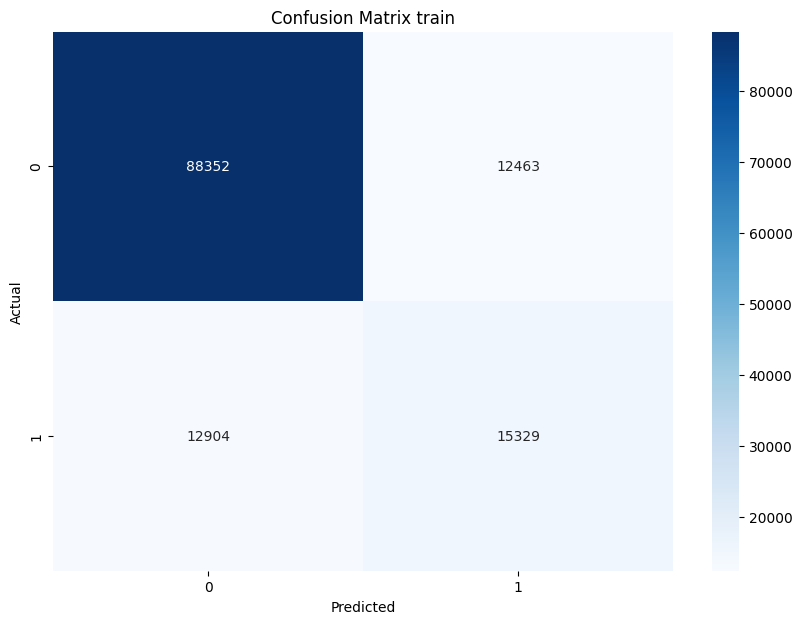

Accuracy: 0.8034297315727481
----------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87    100815
           1       0.55      0.54      0.55     28233

    accuracy                           0.80    129048
   macro avg       0.71      0.71      0.71    129048
weighted avg       0.80      0.80      0.80    129048



In [26]:
# 予測結果を二値クラスに変換
pred_labels = submit["pred_class"]

# 混合行列の作成
cm = confusion_matrix(train_y, pred_labels)

# 混合行列の可視化
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix train')
plt.show()

# 精度評価の表示
print("Accuracy:", accuracy_score(train_y, pred_labels))
print('-' * 100)
print("Classification Report:\n", classification_report(train_y, pred_labels))

In [27]:
# 予測の実行(test)
y_pred = model.predict(test_X, num_iteration=model.best_iteration)

# 予測値の代入
test['pred'] = y_pred

/var/folders/f2/dyf3ym2n7kgb2_9yskmdtj0jr9qsrg/T/ipykernel_94723/2506389339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = y_pred


In [28]:
# レースごとに確率が高い馬３頭に1,それ以外に0のラベルを付与する処理
# 空のデータフレームとリストを作成
submit = pd.DataFrame()
pred_list = []

for race in test['race_id'].unique():
    # レースごとのデータを抽出
    data = test[test['race_id'] == race]

    # 確率が高い順に並び替え
    data = data.sort_values(by='pred', ascending=False).reset_index()
    for index, data_ in data.iterrows():
        # 上位3頭に1、それ以外の馬に0のラベルを付与
        if index < 3:
            pred_list.append(1)
        else:
            pred_list.append(0)
    submit = pd.concat([submit, data])

# 予測値を格納
submit['pred_class'] = pred_list

# id順に並び替え
submit = submit.sort_values(by='index', ascending=True)

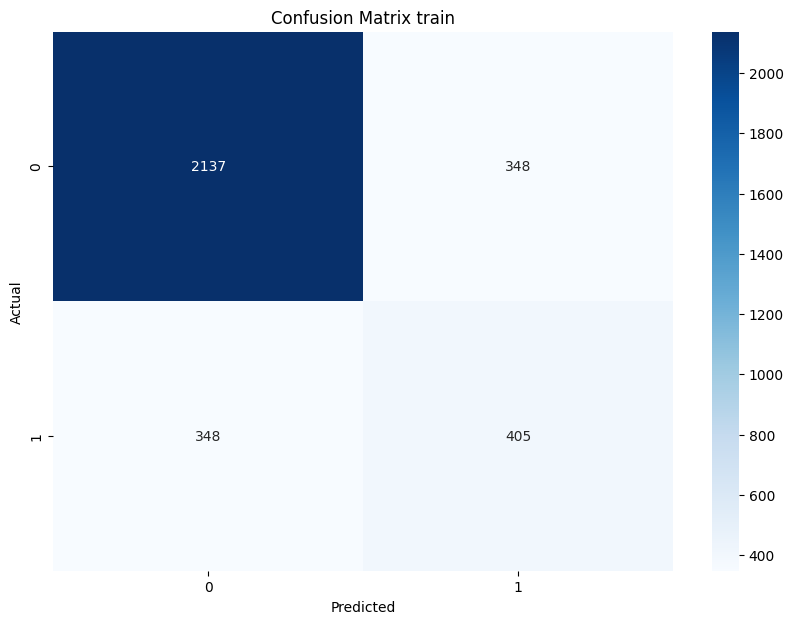

Accuracy: 0.7850525015441631
----------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2485
           1       0.54      0.54      0.54       753

    accuracy                           0.79      3238
   macro avg       0.70      0.70      0.70      3238
weighted avg       0.79      0.79      0.79      3238



In [29]:
# 予測結果を二値クラスに変換
pred_labels = submit["pred_class"]

# 混合行列の作成
cm = confusion_matrix(test_y, pred_labels)

# 混合行列の可視化
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix train')
plt.show()

# 精度評価の表示
print("Accuracy:", accuracy_score(test_y, pred_labels))
print('-' * 100)
print("Classification Report:\n", classification_report(test_y, pred_labels))

In [30]:
# 05_馬券の購入シミュレーション.ipynbで使うためのデータを保存
submit[["race_id", "horse_number", "finish_position", "target", "pred" ,"pred_class"]].to_csv("/content/drive/MyDrive/競馬分析/simulation_data/simulation_20241103.csv", index=False)